Import libraries

In [1]:
import math
import matplotlib
import numpy as np
import json
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import csv
from datetime import date, timedelta, datetime
import os.path
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors
import cartopy.feature
from pysolar.solar import get_altitude
import xarray as xr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Read in the model CVAO ozone data

In [2]:
# Create a function to process the model output into a dataframe
def process_model_output_file(file_name, directory_path):
    if "zsurf_stash34001" not in file_name:
        # Skip files that do not contain "stash34001" in their names
        return None

    file_path = os.path.join(directory_path, file_name)

    with Dataset(file_path, 'r') as nc_file:
        data = {}  # Create an empty dictionary to store variable data

        # Define the variables you want and add them to the dictionary
        variable_list = ['time', 'latitude', 'longitude', 'region', 'm01s34i001']

        for variable in variable_list:
            data[variable] = nc_file.variables[variable][:]
    
    # Create a DataFrame for the current file
    return pd.DataFrame(data)

# Specify the directory path
directory_path = "/scratch/ajp255/homes/mrr32/home/data/PartIII_23/Model_Output"

# List all NetCDF files in the directory containing "stash34001" in their names
file_list = [f for f in os.listdir(directory_path) if f.endswith(".nc") and "stash34001" in f]

# Initialize an empty list to store DataFrames
dfs = []

# Iterate through the filtered files
for file_name in file_list:
    df = process_model_output_file(file_name, directory_path)
    if df is not None:
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
model_data = pd.concat(dfs, ignore_index=True)

# Convert O3 model data to ppbv
cfactor = 1.e9 / 1.657
model_data = model_data.rename(columns={'m01s34i001': 'ozone'})
model_data['ozone'] = model_data['ozone']*cfactor

# Sort the DataFrame by the 'time' column in ascending order
model_data = model_data.sort_values(by='time', ascending=True)
mod_cvao = model_data[model_data['region'] == 'CVAO_O3']

mod_cvao

,time,latitude,longitude,region,ozone
2407144,38990.627083,16.8636,-24.867201,CVAO_O3,34.887379
2407145,38990.627778,16.8636,-24.867201,CVAO_O3,34.885227
2407146,38990.628472,16.8636,-24.867201,CVAO_O3,34.883076
2407147,38990.629167,16.8636,-24.867201,CVAO_O3,34.880924
2407148,38990.629861,16.8636,-24.867201,CVAO_O3,34.878773
...,...,...,...,...,...
3744710,44710.954861,16.8636,-24.867201,CVAO_O3,31.415335
3744711,44710.955556,16.8636,-24.867201,CVAO_O3,31.417304
3744712,44710.956250,16.8636,-24.867201,CVAO_O3,31.419272
3744713,44710.956944,16.8636,-24.867201,CVAO_O3,31.421240


Read in the observation CVAO ozone data

In [3]:
# Specify the directory containing the files
directory_path = '/scratch/ajp255/homes/mrr32/home/data/PartIII_23/CVAO/O3'

# List all files in the directory
file_names = os.listdir(directory_path)

# Create a Pandas DataFrame from the file names
df = pd.DataFrame({'file_name': file_names})

# Extract information from file names
df['base_date'] = df['file_name'].str.extract(r'(\d{8})')

# Convert 'base_date' to datetime format
df['base_date'] = pd.to_datetime(df['base_date'], format='%Y%m%d')
df = df.sort_values(by='base_date', ascending=True)

def process_netcdf_file(file_info, directory_path):
    name, base_date = file_info
    file_path = os.path.join(directory_path, name)

    with Dataset(file_path, 'r') as nc_file:
        data = {}  # Create an empty dictionary to store variable data

        # Define the variables you want and add them to the dictionary
        variable_list = ['time', 'latitude', 'longitude', 'o3_concentration_in_air', 'qc_flag']

        for variable in variable_list:
            if variable in nc_file.variables:
                if variable == 'o3_concentration_in_air':
                    data['ozone'] = nc_file.variables[variable][:]
                else:
                    data[variable] = nc_file.variables[variable][:]

        # Repeat latitude and longitude values for every row
        if 'latitude' in data:
            data['latitude'] = np.repeat(data['latitude'], len(data['time']))

        # Set constant longitude for every row (from observatory coordinates)
        constant_longitude = -24.8672  
        data['longitude'] = np.full(len(data['time']), constant_longitude)
        
        # Create a new column 'altitude' and assign a value of 45 for every row
        #data['altitude'] = 300
        
        # Convert time to days
        sec_per_day = 24 * 60 * 60
        data['time'] = data['time'] / sec_per_day

    # Create a DataFrame for the current file
    return pd.DataFrame(data)

# Create an empty list to store individual DataFrames
dataframes = []

for name, base_date in zip(df['file_name'], df['base_date']):
    result = process_netcdf_file((name, base_date), directory_path)
    if result is not None:
        dataframes.append(result)

# Concatenate all individual DataFrames into a single DataFrame
obs_cvao = pd.concat(dataframes, ignore_index=True)

model_base_date = datetime(1900, 1, 1)
model_start_date = datetime(1986, 1, 1)
obs_base_date = datetime(1970, 1, 1)
start_days_difference = (model_start_date - model_base_date).days
last_model_date = 44710.957639
obs_cvao['time'] = obs_cvao['time'] + (obs_base_date - model_base_date).days
obs_cvao = obs_cvao[(obs_cvao['time'] >= start_days_difference) & (obs_cvao['time'] <= last_model_date)]
obs_cvao = obs_cvao.sort_values(by='time', ascending=True)

obs_cvao

,time,latitude,longitude,ozone,qc_flag
0,38990.627083,16.8636,-24.8672,20.58,1.0
1,38990.627778,16.8636,-24.8672,18.60,1.0
2,38990.628472,16.8636,-24.8672,16.14,1.0
3,38990.629167,16.8636,-24.8672,17.31,1.0
4,38990.629861,16.8636,-24.8672,14.84,1.0
...,...,...,...,...,...
7880516,44710.954861,16.8636,-24.8672,20.29,1.0
7880517,44710.955556,16.8636,-24.8672,19.82,1.0
7880518,44710.956250,16.8636,-24.8672,20.43,1.0
7880519,44710.956944,16.8636,-24.8672,19.98,1.0


Merge datasets

In [4]:
# Reset indices to ensure alignment
mod_cvao_reset = mod_cvao.reset_index(drop=True)
obs_cvao_reset = obs_cvao.reset_index(drop=True)

# Create merge_ozone
merge_ozone = pd.DataFrame()

# Copy time, latitude, and longitude columns from mod_cvao to merge_ozone
merge_ozone['time'] = mod_cvao_reset['time'].copy()
merge_ozone['latitude'] = mod_cvao_reset['latitude'].copy()
merge_ozone['longitude'] = mod_cvao_reset['longitude'].copy()
merge_ozone['mod_ozone'] = mod_cvao_reset['ozone'].copy()
merge_ozone['obs_ozone'] = obs_cvao_reset['ozone'].copy()

# Calculate ozone_mergeerence as mod_cvao['ozone'] - obs_cvao['ozone']
merge_ozone['ozone_difference'] = mod_cvao_reset['ozone'] - obs_cvao_reset['ozone']

# Drop rows where either "mod_ozone" or "obs_ozone" is NaN
merge_ozone = merge_ozone.dropna(subset=['mod_ozone', 'obs_ozone'])
merge_ozone = merge_ozone[merge_ozone['obs_ozone'] > 0.5]

# Display the mergeing DataFrame
merge_ozone

,time,latitude,longitude,mod_ozone,obs_ozone,ozone_difference
0,38990.627083,16.8636,-24.867201,34.887379,20.58,14.307379
1,38990.627778,16.8636,-24.867201,34.885227,18.60,16.285227
2,38990.628472,16.8636,-24.867201,34.883076,16.14,18.743076
3,38990.629167,16.8636,-24.867201,34.880924,17.31,17.570924
4,38990.629861,16.8636,-24.867201,34.878773,14.84,20.038773
...,...,...,...,...,...,...
7880516,44710.954861,16.8636,-24.867201,31.415335,20.29,11.125335
7880517,44710.955556,16.8636,-24.867201,31.417304,19.82,11.597304
7880518,44710.956250,16.8636,-24.867201,31.419272,20.43,10.989272
7880519,44710.956944,16.8636,-24.867201,31.421240,19.98,11.441240


Repeat the same for CO data

In [5]:
# Create a function to process the model output into a dataframe
def process_model_output_file(file_name, directory_path):
    if "zsurf_stash34010" not in file_name:
        # Skip files that do not contain "stash34001" in their names
        return None

    file_path = os.path.join(directory_path, file_name)

    with Dataset(file_path, 'r') as nc_file:
        data = {}  # Create an empty dictionary to store variable data

        # Define the variables you want and add them to the dictionary
        variable_list = ['time', 'latitude', 'longitude', 'region', 'm01s34i010']

        for variable in variable_list:
            data[variable] = nc_file.variables[variable][:]
    
    # Create a DataFrame for the current file
    return pd.DataFrame(data)

# Specify the directory path
directory_path = "/scratch/ajp255/homes/mrr32/home/data/PartIII_23/Model_Output"

# List all NetCDF files in the directory containing "stash34001" in their names
file_list = [f for f in os.listdir(directory_path) if f.endswith(".nc") and "stash34010" in f]

# Initialize an empty list to store DataFrames
dfs = []

# Iterate through the filtered files
for file_name in file_list:
    df = process_model_output_file(file_name, directory_path)
    if df is not None:
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
mod_co_data = pd.concat(dfs, ignore_index=True)

# Convert O3 model data to ppbv
cfactor = 1.e9 / 0.972
mod_co_data = mod_co_data.rename(columns={'m01s34i010': 'co'})
mod_co_data['co'] = mod_co_data['co']*cfactor

# Sort the DataFrame by the 'time' column in ascending order
mod_co_data = mod_co_data.sort_values(by='time', ascending=True)
mod_co_data = mod_co_data[mod_co_data['region'] == 'CVAO_O3']

# Specify the directory containing the files
directory_path = '/scratch/ajp255/homes/mrr32/home/data/PartIII_23/CVAO/CO'

# List all files in the directory
file_names = os.listdir(directory_path)

# Create a Pandas DataFrame from the file names
df = pd.DataFrame({'file_name': file_names})

# Extract information from file names
df['base_date'] = df['file_name'].str.extract(r'(\d{8})')

# Convert 'base_date' to datetime format
df['base_date'] = pd.to_datetime(df['base_date'], format='%Y%m%d')
df = df.sort_values(by='base_date', ascending=True)

def process_netcdf_file(file_info, directory_path):
    name, base_date = file_info
    file_path = os.path.join(directory_path, name)

    with Dataset(file_path, 'r') as nc_file:
        data = {}  # Create an empty dictionary to store variable data

        # Define the variables you want and add them to the dictionary
        variable_list = ['time', 'latitude', 'longitude', 'co_concentration_in_air', 'qc_flag']

        for variable in variable_list:
            if variable in nc_file.variables:
                if variable == 'co_concentration_in_air':
                    data['co'] = nc_file.variables[variable][:]
                else:
                    data[variable] = nc_file.variables[variable][:]

        # Repeat latitude and longitude values for every row
        if 'latitude' in data:
            data['latitude'] = np.repeat(data['latitude'], len(data['time']))

        # Set constant longitude for every row (from observatory coordinates)
        constant_longitude = -24.8672  
        data['longitude'] = np.full(len(data['time']), constant_longitude)
        
        # Create a new column 'altitude' and assign a value of 45 for every row
        #data['altitude'] = 300
        
        # Convert time to days
        sec_per_day = 24 * 60 * 60
        data['time'] = data['time'] / sec_per_day

    # Create a DataFrame for the current file
    return pd.DataFrame(data)

# Create an empty list to store individual DataFrames
dataframes = []

for name, base_date in zip(df['file_name'], df['base_date']):
    result = process_netcdf_file((name, base_date), directory_path)
    if result is not None:
        dataframes.append(result)

# Concatenate all individual DataFrames into a single DataFrame
obs_co_data = pd.concat(dataframes, ignore_index=True)

model_base_date = datetime(1900, 1, 1)
model_start_date = datetime(1986, 1, 1)
obs_base_date = datetime(1970, 1, 1)
start_days_difference = (model_start_date - model_base_date).days
last_model_date = 44710.957639
obs_co_data['time'] = obs_co_data['time'] + (obs_base_date - model_base_date).days
obs_co_data = obs_co_data[(obs_co_data['time'] >= start_days_difference) & (obs_co_data['time'] <= last_model_date)]
obs_co_data = obs_co_data.sort_values(by='time', ascending=True)

# Reset indices to ensure alignment
mod_cvao_reset = mod_co_data.reset_index(drop=True)
obs_cvao_reset = obs_co_data.reset_index(drop=True)

# Create merge_df
merge_co = pd.DataFrame()

# Copy time, latitude, and longitude columns from mod_cvao to merge_df
merge_co['time'] = obs_cvao_reset['time'].copy()
merge_co['latitude'] = obs_cvao_reset['latitude'].copy()
merge_co['longitude'] = obs_cvao_reset['longitude'].copy()
merge_co['mod_co'] = mod_cvao_reset['co'].copy()
merge_co['obs_co'] = obs_cvao_reset['co'].copy()

# Calculate co_mergeerence as mod_cvao['co'] - obs_cvao['co']
merge_co['co_difference'] = mod_cvao_reset['co'] - obs_cvao_reset['co']

# Drop rows where either "mod_co" or "obs_co" is NaN
merge_co = merge_co.dropna(subset=['mod_co', 'obs_co'])
merge_co = merge_co.sort_values(by='time', ascending=True)

# Display the mergeing DataFrame
merge_co

,time,latitude,longitude,mod_co,obs_co,co_difference
0,43099.000000,52.9506,-24.8672,65.060694,91.94,-26.879306
1006,43099.000000,52.9506,-24.8672,67.387717,93.54,-26.152283
1005,43099.000000,52.9506,-24.8672,67.386008,92.98,-25.593992
1004,43099.000000,52.9506,-24.8672,67.384300,93.91,-26.525700
1003,43099.000000,52.9506,-24.8672,67.382591,92.43,-25.047409
...,...,...,...,...,...,...
2024579,44710.954861,52.9506,-24.8672,83.176549,77.04,6.136549
2024580,44710.955556,52.9506,-24.8672,83.177500,79.18,3.997500
2024581,44710.956250,52.9506,-24.8672,83.178450,78.16,5.018450
2024582,44710.956944,52.9506,-24.8672,83.179401,81.46,1.719401


Interannual variability of observation and model data

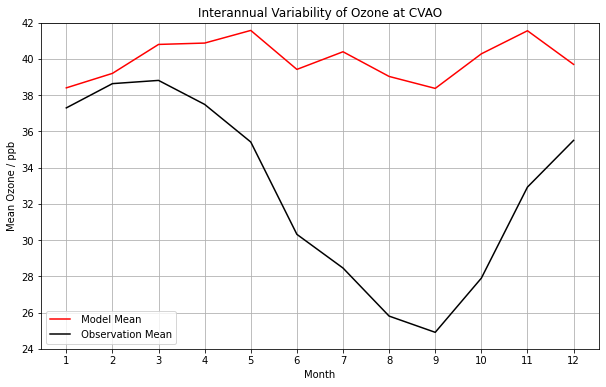

In [6]:
# Convert 'datetime' column to datedatetime if not already done
merge_ozone['datetime'] = pd.to_datetime(merge_ozone['time'], origin='1900-01-01', unit='D')

# Extract the month from the 'datetime' column
merge_ozone['month'] = merge_ozone['datetime'].dt.month

# Initialize dictionaries to store mean values for each variable
mean_values = {
    'mod_ozone': [],
    'obs_ozone': []
}

# Calculate mean values for each month and store them in the dictionaries
for month in range(1, 13):
    for column in mean_values.keys():
        mean_val = merge_ozone[merge_ozone['month'] == month][column].mean()
        mean_values[column].append(mean_val)

months = list(range(1, 13))

# Plotting for each variable on the same graph
plt.figure(figsize=(10, 6))

colors = {'mod_ozone': 'r', 'obs_ozone': 'k'}  # Define colors for each variable

for column, mean_vals in mean_values.items():
    label = 'Model' if column == 'mod_ozone' else 'Observation'
    plt.plot(months, mean_vals, linestyle='-', label=f' {label} Mean', color=colors[column])

plt.xlabel('Month')
plt.ylabel('Mean Ozone / ppb')
plt.ylim(24, 42)  # Assuming this is the correct range for both variables
plt.title('Interannual Variability of Ozone at CVAO')
plt.xticks(months)
plt.grid(True)
plt.legend()
plt.savefig('/home/ajp255/nethome/Data/ChlAPlots/CVAO_model_vs_obs.png', dpi=600)

plt.show()

Histogram of model and observed ozone data

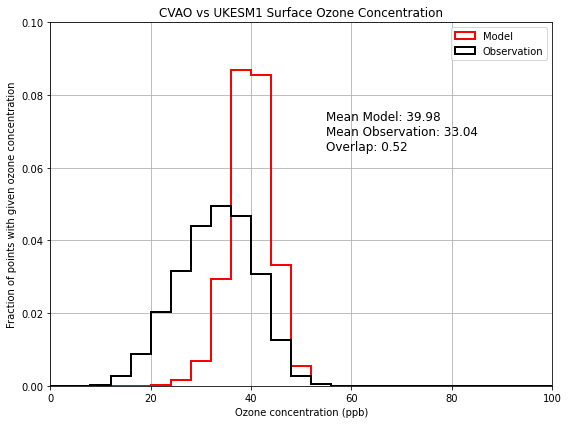

In [8]:
# Specify the directory to save plots
save_dir = '/home/ajp255/nethome/Data/Plots/'

# Extract ozone data
model_ozone = merge_ozone['mod_ozone']
ship_ozone = merge_ozone['obs_ozone']

# Define histogram bins and range
binsize = 4
binstart = 0
binend = 100

# Calculate mean for each dataset
mean_model = np.mean(model_ozone)
mean_ship = np.mean(ship_ozone)

# Calculate degree of overlap
overlap = np.sum(np.minimum(np.histogram(model_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0],
                            np.histogram(ship_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0])) / len(model_ozone)

# Plot histograms for the entire dataset
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

n_model, bins_model, patches_model = plt.hist(model_ozone, bins=np.arange(binstart, binend + binsize, binsize),
                                              density=True, histtype='step', facecolor='red', edgecolor='red',
                                              linewidth=2, label="Model")

n_ship, bins_ship, patches_ship = plt.hist(ship_ozone, bins=np.arange(binstart, binend + binsize, binsize),
                                           density=True, histtype='step', facecolor='None', edgecolor='black',
                                           linewidth=2, label="Observation")

# Customize plot
plt.xlabel('Ozone concentration (ppb)')
plt.ylabel('Fraction of points with given ozone concentration')
plt.title('CVAO vs UKESM1 Surface Ozone Concentration')
plt.xlim(0, 100)  # Adjust xlim as needed
plt.ylim(0, 0.1)  # Adjust ylim as needed
plt.grid(True)
plt.legend(loc='upper right')

# Add mean and overlap information on the plot
info_text = f'Mean Model: {mean_model:.2f}\nMean Observation: {mean_ship:.2f}\nOverlap: {overlap:.2f}'
plt.text(0.55, 0.7, info_text, transform=plt.gca().transAxes, fontsize=12, va='center', ha='left')

# Save the plot to a file
save_path = os.path.join(save_dir, 'CVAO_ozone_histogram_all_data.png')
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

# Close the current figure
plt.close()

Histogram of model and observed CO data

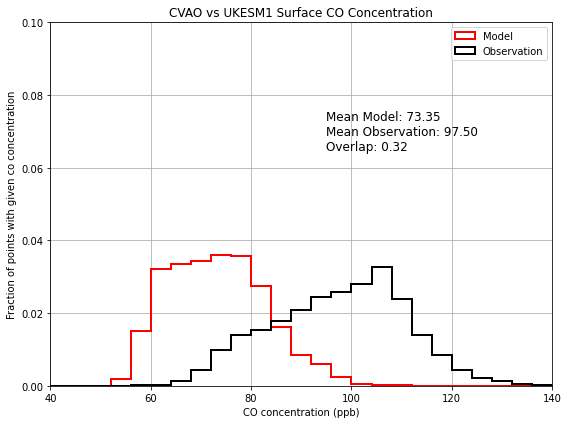

In [9]:
# Specify the directory to save plots
save_dir = '/home/ajp255/nethome/Data/Plots/'

# Extract co data
model_co = merge_co['mod_co']
ship_co = merge_co['obs_co']

# Define histogram bins and range
binsize = 4
binstart = 0
binend = 150

# Calculate mean for each dataset
mean_model = np.mean(model_co)
mean_ship = np.mean(ship_co)

# Calculate degree of overlap
overlap = np.sum(np.minimum(np.histogram(model_co, bins=np.arange(binstart, binend + binsize, binsize))[0],
                            np.histogram(ship_co, bins=np.arange(binstart, binend + binsize, binsize))[0])) / len(model_co)

# Plot histograms for the entire dataset
plt.figure(figsize=(8, 6))  # Adjust figure size as needed

n_model, bins_model, patches_model = plt.hist(model_co, bins=np.arange(binstart, binend + binsize, binsize),
                                              density=True, histtype='step', facecolor='red', edgecolor='red',
                                              linewidth=2, label="Model")

n_ship, bins_ship, patches_ship = plt.hist(ship_co, bins=np.arange(binstart, binend + binsize, binsize),
                                           density=True, histtype='step', facecolor='None', edgecolor='black',
                                           linewidth=2, label="Observation")

# Customize plot
plt.xlabel('CO concentration (ppb)')
plt.ylabel('Fraction of points with given co concentration')
plt.title('CVAO vs UKESM1 Surface CO Concentration')
plt.xlim(40, 140)  # Adjust xlim as needed
plt.ylim(0, 0.1)  # Adjust ylim as needed
plt.grid(True)
plt.legend(loc='upper right')

# Add mean and overlap information on the plot
info_text = f'Mean Model: {mean_model:.2f}\nMean Observation: {mean_ship:.2f}\nOverlap: {overlap:.2f}'
plt.text(0.55, 0.7, info_text, transform=plt.gca().transAxes, fontsize=12, va='center', ha='left')

# Save the plot to a file
#save_path = os.path.join(save_dir, 'CVAO_CO_histogram_all_data.png')
#plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

# Close the current figure
plt.close()

Average the data at hourly frequency and combine ozone and CO data

In [10]:
merged_cvao = pd.merge(merge_co, merge_ozone, on='time', how='inner')
merged_cvao['time'] = pd.to_datetime(merged_cvao['time'], origin='1900-01-01', unit='D')
hourly_cvao_data = merged_cvao.groupby(pd.Grouper(key='time', freq='h')).mean()
hourly_cvao_data = hourly_cvao_data.drop(columns=['latitude_y', 'longitude_y'])

hourly_cvao_data

,latitude_x,longitude_x,mod_co,obs_co,co_difference,mod_ozone,obs_ozone,ozone_difference,datetime,month
time,,,,,,,,,,
2019-01-01 01:00:00,52.9506,-24.8672,65.719075,82.159836,-16.440761,39.609800,35.315410,4.294390,2019-01-01 01:30:00.000000000,1.0
2019-01-01 02:00:00,52.9506,-24.8672,65.675514,81.745424,-16.069910,39.602250,35.710339,3.891911,2019-01-01 02:30:00.000000000,1.0
2019-01-01 03:00:00,52.9506,-24.8672,65.653946,82.452500,-16.798554,39.618486,35.192833,4.425653,2019-01-01 03:29:30.000000000,1.0
2019-01-01 04:00:00,52.9506,-24.8672,65.647564,82.549836,-16.902272,39.656921,34.256230,5.400692,2019-01-01 04:30:00.000000000,1.0
2019-01-01 05:00:00,52.9506,-24.8672,65.645827,82.861186,-17.215359,39.723765,33.919153,5.804612,2019-01-01 05:30:00.000000000,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-05-31 18:00:00,52.9506,-24.8672,83.494245,81.052000,2.442245,30.972404,21.745000,9.227404,2022-05-31 18:29:30.000000000,5.0
2022-05-31 19:00:00,52.9506,-24.8672,83.318863,81.079153,2.239710,31.002845,21.667373,9.335472,2022-05-31 19:29:11.186440704,5.0
2022-05-31 20:00:00,52.9506,-24.8672,83.205745,80.897797,2.307949,31.085784,21.949831,9.135953,2022-05-31 20:30:00.000000000,5.0


Use PySolar to get SZA

In [11]:
def calculate_solar_zenith_angle(row):
    # Localize the timestamp to the Cape Verde timezone
    timestamp = row.name.tz_localize('Atlantic/Cape_Verde')
    # Get altitude using pysolar
    altitude = get_altitude(row['latitude_x'], row['longitude_x'], timestamp)
    # Solar zenith angle is 90 degrees minus the solar altitude
    return 90 - altitude

# Apply the function to each row
hourly_cvao_data['solar_zenith_angle'] = hourly_cvao_data.apply(calculate_solar_zenith_angle, axis=1)

hourly_cvao_data

,latitude_x,longitude_x,mod_co,obs_co,co_difference,mod_ozone,obs_ozone,ozone_difference,datetime,month,solar_zenith_angle
time,,,,,,,,,,,
2019-01-01 01:00:00,52.9506,-24.8672,65.719075,82.159836,-16.440761,39.609800,35.315410,4.294390,2019-01-01 01:30:00.000000000,1.0,149.901042
2019-01-01 02:00:00,52.9506,-24.8672,65.675514,81.745424,-16.069910,39.602250,35.710339,3.891911,2019-01-01 02:30:00.000000000,1.0,146.663914
2019-01-01 03:00:00,52.9506,-24.8672,65.653946,82.452500,-16.798554,39.618486,35.192833,4.425653,2019-01-01 03:29:30.000000000,1.0,140.365419
2019-01-01 04:00:00,52.9506,-24.8672,65.647564,82.549836,-16.902272,39.656921,34.256230,5.400692,2019-01-01 04:30:00.000000000,1.0,132.345977
2019-01-01 05:00:00,52.9506,-24.8672,65.645827,82.861186,-17.215359,39.723765,33.919153,5.804612,2019-01-01 05:30:00.000000000,1.0,123.536101
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31 18:00:00,52.9506,-24.8672,83.494245,81.052000,2.442245,30.972404,21.745000,9.227404,2022-05-31 18:29:30.000000000,5.0,67.062605
2022-05-31 19:00:00,52.9506,-24.8672,83.318863,81.079153,2.239710,31.002845,21.667373,9.335472,2022-05-31 19:29:11.186440704,5.0,75.847374
2022-05-31 20:00:00,52.9506,-24.8672,83.205745,80.897797,2.307949,31.085784,21.949831,9.135953,2022-05-31 20:30:00.000000000,5.0,84.031305


Extract physical variables from ERA5 dataset

In [12]:
# Directory path
directory_path = '/home/ajp255/nethome/Data/ERA5_data/'

# Get all file names in the directory
file_names = os.listdir(directory_path)

# Filter files with "merge_2006_2018" in their names
file_paths = [os.path.join(directory_path, f) for f in file_names if "2006_2018" in f]

# Function to convert xarray Dataset to pandas DataFrame
def xr_to_df(ds):
    # Convert dataset to DataFrame
    df = ds.to_dataframe().reset_index()
    return df

# Initialize empty DataFrames
dfs = []

# Iterate over file paths
for file_path in file_paths:
    # Open NetCDF file using xarray
    ds = xr.open_dataset(file_path)
    
    # Convert dataset to DataFrame and append to list
    df = xr_to_df(ds)
    dfs.append(df)

# Merge DataFrames based on latitude, longitude, and time
merge_2006_2018 = pd.concat(dfs).groupby(['latitude', 'longitude', 'time']).first().reset_index()

# Get all file names in the directory
file_names = os.listdir(directory_path)

# Filter files with "2019_2022" in their names
file_paths = [os.path.join(directory_path, f) for f in file_names if "2019_2022" in f]

# Function to convert xarray Dataset to pandas DataFrame
def xr_to_df(ds):
    # Convert dataset to DataFrame
    df = ds.to_dataframe().reset_index()
    return df

# Initialize empty DataFrames
dfs = []

# Iterate over file paths
for file_path in file_paths:
    # Open NetCDF file using xarray
    ds = xr.open_dataset(file_path)
    
    # Convert dataset to DataFrame and append to list
    df = xr_to_df(ds)
    dfs.append(df)

# Merge DataFrames based on latitude, longitude, and time
merge_2019_2022 = pd.concat(dfs).groupby(['latitude', 'longitude', 'time']).first().reset_index()

# Concatenate the DataFrames merge_2006_2018 and merge_2019_2022
physical_vars = pd.concat([merge_2006_2018, merge_2019_2022], ignore_index=True)

# Calculate wind speed
physical_vars['wind_speed'] = np.sqrt(physical_vars['u10']**2 + physical_vars['v10']**2)

# Calculate wind direction
physical_vars['wind_direction'] = np.arctan2(physical_vars['u10'], physical_vars['v10']) * (180 / np.pi)

# Display the concatenated DataFrame
physical_vars

,latitude,longitude,time,tp,u10,sp,blh,v10,ssrc,t2m,ssr,o3,wind_speed,wind_direction
0,16.0,-26.0,2006-01-01 00:00:00,9.313226e-10,-7.352587,101535.476562,885.139893,-3.786325,-0.125,296.678314,-0.125,NaN,8.270235,-117.246891
1,16.0,-26.0,2006-01-01 01:00:00,9.313226e-10,-7.007782,101492.710938,869.514404,-3.684158,-0.125,296.608215,-0.125,NaN,7.917199,-117.731971
2,16.0,-26.0,2006-01-01 02:00:00,9.313226e-10,-6.770461,101459.648438,873.711487,-3.528882,-0.125,296.585327,-0.125,NaN,7.634929,-117.529305
3,16.0,-26.0,2006-01-01 03:00:00,9.313226e-10,-6.678026,101441.890625,889.620544,-3.350652,-0.125,296.547638,-0.125,NaN,7.471472,-116.644878
4,16.0,-26.0,2006-01-01 04:00:00,9.313226e-10,-6.636322,101398.328125,928.925293,-3.352452,-0.125,296.512329,-0.125,NaN,7.435032,-116.801398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12070291,18.0,-24.0,2022-12-31 19:00:00,0.000000e+00,-3.508660,101565.437500,1003.828796,-1.627723,276442.250,295.827362,255844.500,NaN,3.867838,-114.887334
12070292,18.0,-24.0,2022-12-31 20:00:00,0.000000e+00,-3.662231,101661.882812,1017.206848,-1.561801,2225.250,295.813934,1947.000,NaN,3.981351,-113.096383
12070293,18.0,-24.0,2022-12-31 21:00:00,0.000000e+00,-4.024518,101694.617188,1042.543213,-1.496608,-0.125,295.809052,-0.125,NaN,4.293784,-110.398779
12070294,18.0,-24.0,2022-12-31 22:00:00,0.000000e+00,-3.875115,101787.468750,1103.727417,-1.218352,-0.125,295.851288,-0.125,NaN,4.062129,-107.453356


Select data at the CVAO location and tidy variables

In [13]:
selected_rows = physical_vars[(physical_vars['latitude'] == 16.75) & (physical_vars['longitude'] == -24.75)]
selected_rows = selected_rows.drop(columns=['latitude','longitude'])

linregress_df = pd.merge(hourly_cvao_data, selected_rows, on='time', how='inner')
linregress_df = linregress_df.drop(columns=['co_difference', 'u10', 'v10'])
linregress_df = linregress_df.dropna()

linregress_df

,time,latitude_x,longitude_x,mod_co,obs_co,mod_ozone,obs_ozone,ozone_difference,datetime,month,solar_zenith_angle,tp,sp,blh,ssrc,t2m,ssr,o3,wind_speed,wind_direction
0,2019-01-01 01:00:00,52.9506,-24.8672,65.719075,82.159836,39.609800,35.315410,4.294390,2019-01-01 01:30:00.000000000,1.0,149.901042,0.0,101846.273438,603.087646,-0.125,295.402039,-0.125,7.349208e-08,6.925153,-112.017377
1,2019-01-01 02:00:00,52.9506,-24.8672,65.675514,81.745424,39.602250,35.710339,3.891911,2019-01-01 02:30:00.000000000,1.0,146.663914,0.0,101797.578125,577.696655,-0.125,295.360718,-0.125,7.318003e-08,6.729889,-109.493704
2,2019-01-01 03:00:00,52.9506,-24.8672,65.653946,82.452500,39.618486,35.192833,4.425653,2019-01-01 03:29:30.000000000,1.0,140.365419,0.0,101752.906250,544.442627,-0.125,295.369080,-0.125,7.293420e-08,6.565377,-110.605987
3,2019-01-01 04:00:00,52.9506,-24.8672,65.647564,82.549836,39.656921,34.256230,5.400692,2019-01-01 04:30:00.000000000,1.0,132.345977,0.0,101695.054688,523.310791,-0.125,295.350403,-0.125,7.294724e-08,6.695720,-113.770413
4,2019-01-01 05:00:00,52.9506,-24.8672,65.645827,82.861186,39.723765,33.919153,5.804612,2019-01-01 05:30:00.000000000,1.0,123.536101,0.0,101679.750000,512.144165,-0.125,295.381989,-0.125,7.306464e-08,6.791598,-114.015371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29921,2022-05-31 18:00:00,52.9506,-24.8672,83.494245,81.052000,30.972404,21.745000,9.227404,2022-05-31 18:29:30.000000000,5.0,67.062605,0.0,101597.437500,614.172363,1676568.250,296.558167,1603159.000,7.190472e-08,7.952703,-135.078534
29922,2022-05-31 19:00:00,52.9506,-24.8672,83.318863,81.079153,31.002845,21.667373,9.335472,2022-05-31 19:29:11.186440704,5.0,75.847374,0.0,101592.460938,591.784546,906323.750,296.506866,614327.250,7.197094e-08,7.625353,-137.690822
29923,2022-05-31 20:00:00,52.9506,-24.8672,83.205745,80.897797,31.085784,21.949831,9.135953,2022-05-31 20:30:00.000000000,5.0,84.031305,0.0,101587.335938,565.738281,227707.375,296.469543,191480.000,7.199804e-08,7.674896,-141.800123
29924,2022-05-31 21:00:00,52.9506,-24.8672,83.135052,80.362667,31.235856,20.729500,10.506356,2022-05-31 21:29:30.000000000,5.0,91.540417,0.0,101667.960938,572.973389,778.750,296.487152,556.250,7.197296e-08,8.062731,-143.346751


Plot the relationship between each variable and model bias to visualise relationship

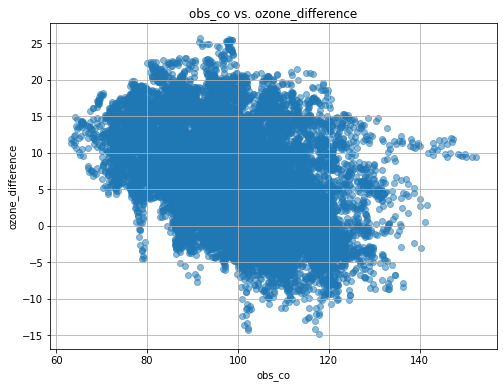

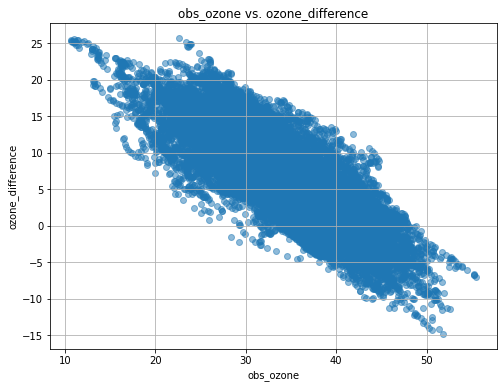

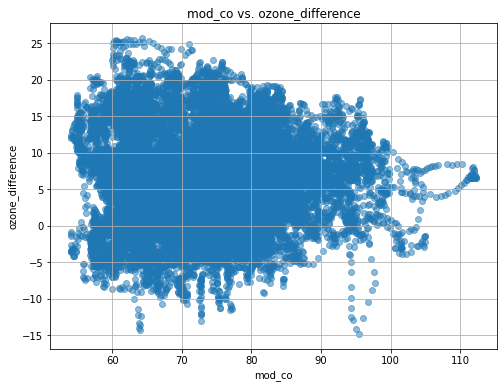

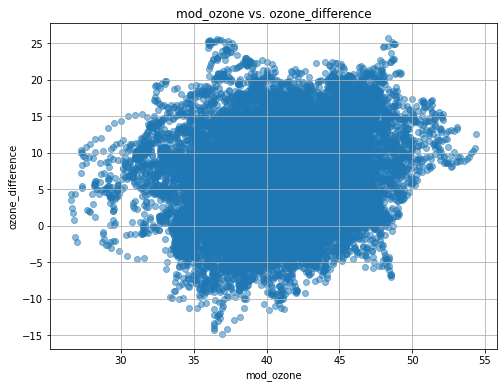

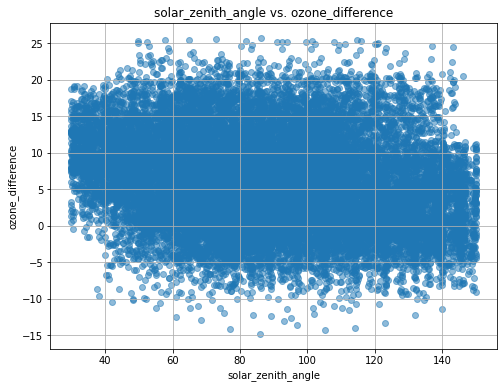

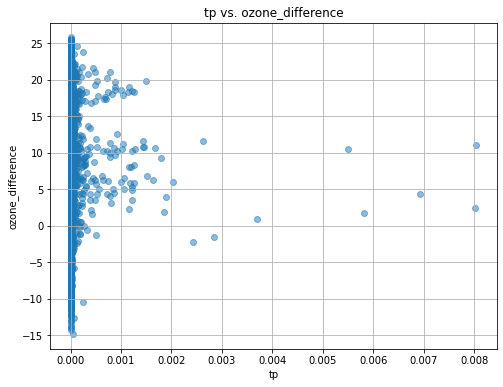

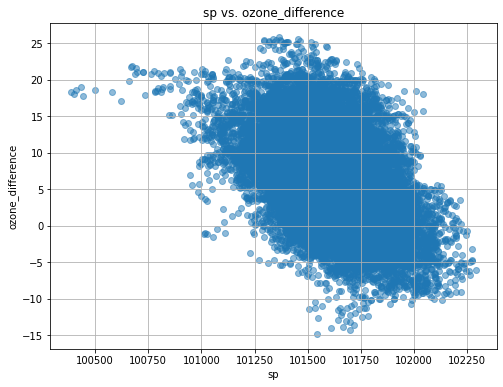

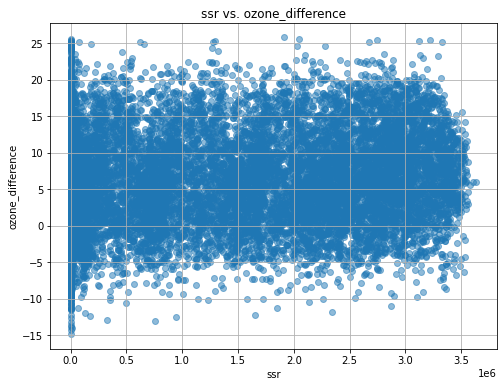

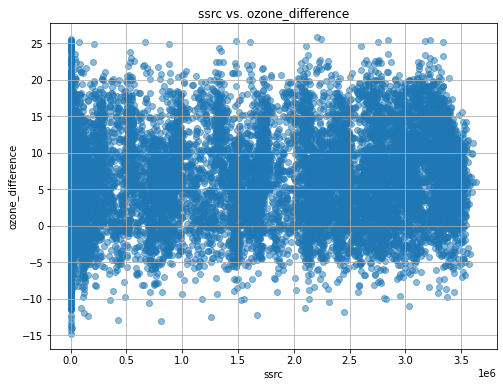

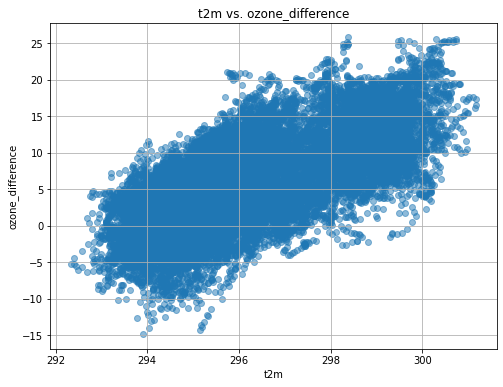

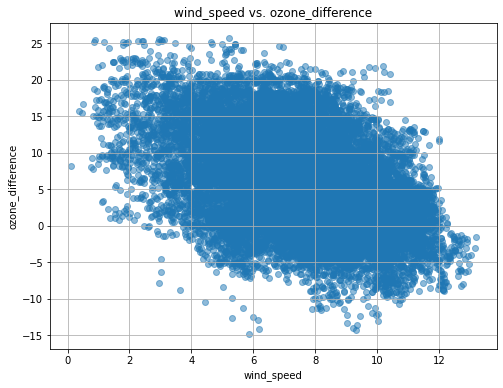

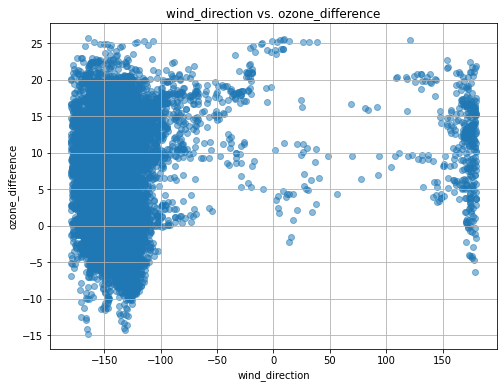

In [14]:
# List of variables to plot
variables = ['obs_co', 'obs_ozone', 'mod_co', 'mod_ozone', 'solar_zenith_angle', 'tp', 'sp', 'ssr', 'ssrc', 't2m', 'wind_speed', 'wind_direction']

# Plot each variable against 'ozone_difference'
for variable in variables:
    plt.figure(figsize=(8, 6))
    plt.scatter(linregress_df[variable], linregress_df['ozone_difference'], alpha=0.5)
    plt.xlabel(variable)
    plt.ylabel('ozone_difference')
    plt.title(f'{variable} vs. ozone_difference')
    plt.grid(True)
    plt.show()

Linear regression with normalisation

Mean Squared Error: 16.117602389874985
Mean Absolute Error: 3.2140734675358558
R-squared: 0.41274257319998553
Coefficients:
obs_co: -7.159810774347168
mod_co: 3.476227656227895
solar_zenith_angle: -3.862656580991336
tp: -10.52218339344696
sp: -4.917060161245928
ssr: -0.5641993949456254
t2m: 18.091049939777534
wind_speed: -4.030183833422052
wind_direction: -1.5239765967008008
Intercept: 7.078890455269282


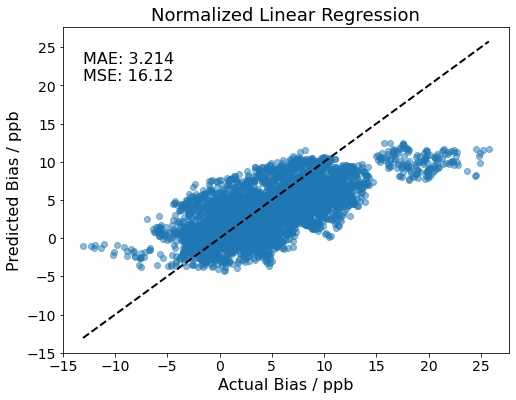

In [15]:
linregress_df_sorted = linregress_df.sort_values(by='time')

# Define the percentage of data to be used for testing
test_size = 0.2

# Calculate the index to split the data
split_index = int(len(linregress_df_sorted) * (1 - test_size))

# Split the dataset based on the calculated index
train_df = linregress_df_sorted.iloc[:split_index]
test_df = linregress_df_sorted.iloc[split_index:]

# Define features and target variable for training and testing sets after the split
X_train = train_df[['obs_co', 'mod_co', 'solar_zenith_angle', 'tp', 'sp', 'ssr', 't2m', 'wind_speed', 'wind_direction']]
y_train = train_df['ozone_difference']
X_test = test_df[['obs_co', 'mod_co', 'solar_zenith_angle', 'tp', 'sp', 'ssr', 't2m', 'wind_speed', 'wind_direction']]
y_test = test_df['ozone_difference']

# Apply min-max normalization to features
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train_normalized, y_train)

# Make predictions
y_pred = model.predict(X_test_normalized)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

# Optional: Print coefficients and intercept
coefficients = {feature: coef for feature, coef in zip(X_train.columns, model.coef_)}
print("Coefficients:")
for feature, coef in coefficients.items():
    print(f"{feature}: {coef}")
print("Intercept:", model.intercept_)

# Plot Observed vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Observed')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='1:1 line')
plt.xlabel("Actual Bias / ppb", fontsize=16)
plt.ylabel("Predicted Bias / ppb", fontsize=16)
plt.title("Normalized Linear Regression", fontsize=18)
plt.text(y_test.min(), y_test.max()*0.95, f'MAE: {mae:.3f}\nMSE: {mse:.2f}', fontsize=16, verticalalignment='top')
plt.tick_params(axis='both', which='major', labelsize=14) 
plt.savefig('/home/ajp255/nethome/Data/MLPlots/linear_regression_plot.png', dpi=600)

plt.show()

Random forest regression

Mean Squared Error: 18.857027638007438
Mean Absolute Error: 3.4353095201649264
R-squared: 0.31292947549384875
              Feature  Importance
6                 t2m    0.574419
1              mod_co    0.115408
0              obs_co    0.087880
8      wind_direction    0.074121
7          wind_speed    0.060162
4                  sp    0.039833
2  solar_zenith_angle    0.026162
5                 ssr    0.011304
3                  tp    0.010712


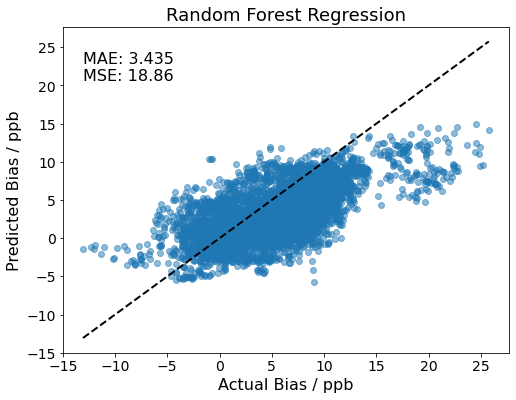

In [16]:
# Define the percentage of data to be used for testing
test_size = 0.2

# Calculate the index to split the data
split_index = int(len(linregress_df_sorted) * (1 - test_size))

# Split the dataset
train_df = linregress_df_sorted.iloc[:split_index]
test_df = linregress_df_sorted.iloc[split_index:]

# Define features and target variable for training and testing sets
X_train = train_df[['obs_co', 'mod_co', 'solar_zenith_angle', 'tp', 'sp', 'ssr', 't2m', 'wind_speed', 'wind_direction']]
y_train = train_df['ozone_difference']
X_test = test_df[['obs_co', 'mod_co', 'solar_zenith_angle', 'tp', 'sp', 'ssr', 't2m', 'wind_speed', 'wind_direction']]
y_test = test_df['ozone_difference']

# Fit the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

# Feature importances
feature_importance = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# Plot Observed vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Observed')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='1:1 line')
plt.xlabel("Actual Bias / ppb", fontsize=16)
plt.ylabel("Predicted Bias / ppb", fontsize=16)
plt.title("Random Forest Regression", fontsize=18)
plt.text(y_test.min(), y_test.max()*0.95, f'MAE: {mae:.3f}\nMSE: {mse:.2f}', fontsize=16, verticalalignment='top')
plt.tick_params(axis='both', which='major', labelsize=14) 

# Save the plot with dpi=600 in a specific directory
plt.savefig('/home/ajp255/nethome/Data/MLPlots/random_forest_plot.png', dpi=600)

plt.show()

Gradient boosting regressor

Mean Squared Error: 16.371902552994086
Mean Absolute Error: 3.202311218648577
R-squared: 0.4034769482133582
              Feature  Importance
6                 t2m    0.726863
0              obs_co    0.068764
1              mod_co    0.065100
8      wind_direction    0.050328
7          wind_speed    0.040163
4                  sp    0.022927
2  solar_zenith_angle    0.020285
3                  tp    0.004630
5                 ssr    0.000941


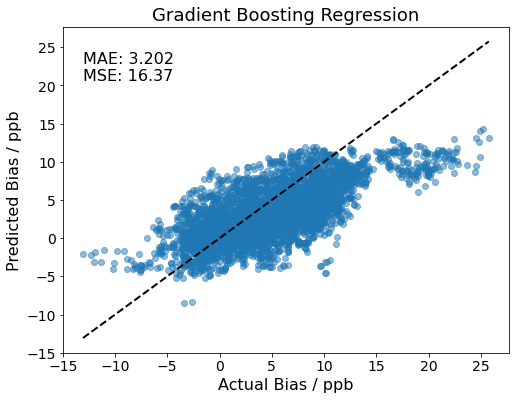

In [17]:
# Define the percentage of data to be used for testing
test_size = 0.2

# Calculate the index to split the data
split_index = int(len(linregress_df_sorted) * (1 - test_size))

# Split the dataset
train_df = linregress_df_sorted.iloc[:split_index]
test_df = linregress_df_sorted.iloc[split_index:]

# Define features and target variable for training and testing sets
X_train = train_df[['obs_co', 'mod_co', 'solar_zenith_angle', 'tp', 'sp', 'ssr', 't2m', 'wind_speed', 'wind_direction']]
y_train = train_df['ozone_difference']
X_test = test_df[['obs_co', 'mod_co', 'solar_zenith_angle', 'tp', 'sp', 'ssr', 't2m', 'wind_speed', 'wind_direction']]
y_test = test_df['ozone_difference']

# Fit the model
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

# Feature importances
feature_importance = model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# Plot Observed vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Observed')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='1:1 line')
plt.xlabel("Actual Bias / ppb", fontsize=16)
plt.ylabel("Predicted Bias / ppb", fontsize=16)
plt.title("Gradient Boosting Regression", fontsize=18)
plt.text(y_test.min(), y_test.max()*0.95, f'MAE: {mae:.3f}\nMSE: {mse:.2f}', fontsize=16, verticalalignment='top')
plt.tick_params(axis='both', which='major', labelsize=14) 

# Save the plot with dpi=600 in a specific directory
plt.savefig('/home/ajp255/nethome/Data/MLPlots/gradient_boosting_plot.png', dpi=600)
plt.show()

Mean Squared Error: 15.01074302790288
Mean Absolute Error: 3.076248016580918
R-squared: 0.4530718582274892
Optimized Hyperparameters: {'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 85}
              Feature  Importance
6                 t2m    0.570079
0              obs_co    0.116807
4                  sp    0.092422
7          wind_speed    0.082219
8      wind_direction    0.053224
1              mod_co    0.039512
2  solar_zenith_angle    0.037696
3                  tp    0.005854
5                 ssr    0.002187


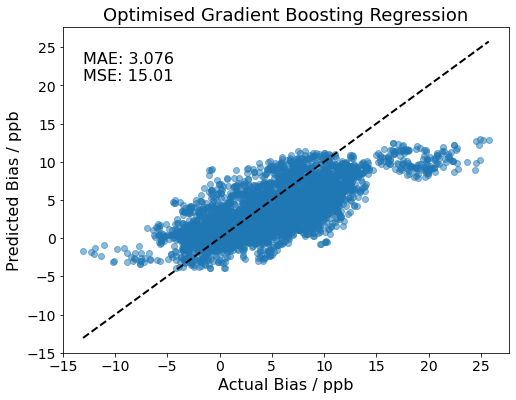

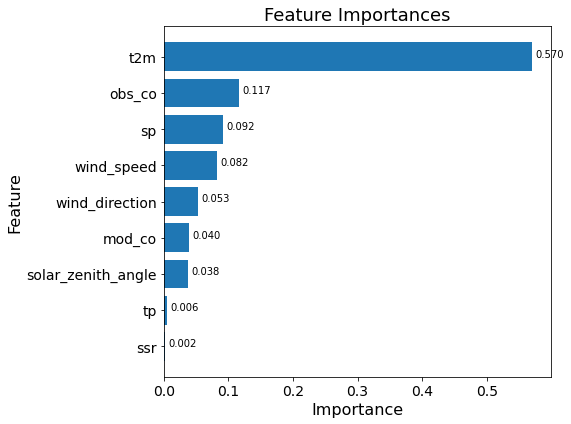

In [18]:
# Define the percentage of data to be used for testing
test_size = 0.2

# Calculate the index to split the data
split_index = int(len(linregress_df_sorted) * (1 - test_size))

# Split the dataset based on the calculated index
train_df = linregress_df_sorted.iloc[:split_index]
test_df = linregress_df_sorted.iloc[split_index:]

# Define features and target variable for training and testing sets after the split
X_train = train_df[['obs_co', 'mod_co', 'solar_zenith_angle', 'tp', 'sp', 'ssr', 't2m', 'wind_speed', 'wind_direction']]
y_train = train_df['ozone_difference']
X_test = test_df[['obs_co', 'mod_co', 'solar_zenith_angle', 'tp', 'sp', 'ssr', 't2m', 'wind_speed', 'wind_direction']]
y_test = test_df['ozone_difference']

# Define your model
gbr = GradientBoostingRegressor(random_state=42)

# Define hyperparameter grid for GradientBoostingRegressor
param_grid = {
    'n_estimators': [60, 85, 100],
    'learning_rate': [0.04, 0.05, 0.06],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'max_features': ['sqrt', 'log2']
}

# Define cross-validation split using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define GridSearchCV for parameter search
model = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=tscv,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

# Print optimized hyperparameters
print("Optimized Hyperparameters:", model.best_params_)

# Feature importances
feature_importance = model.best_estimator_.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

# Plot Observed vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Observed')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='1:1 line')
plt.xlabel("Actual Bias / ppb", fontsize=16)
plt.ylabel("Predicted Bias / ppb", fontsize=16)
plt.title("Optimised Gradient Boosting Regression", fontsize=18)
plt.text(y_test.min(), y_test.max()*0.95, f'MAE: {mae:.3f}\nMSE: {mse:.2f}', fontsize=16, verticalalignment='top')
plt.tick_params(axis='both', which='major', labelsize=14) 

# Save the plot with dpi=600 in a specific directory
plt.savefig('/home/ajp255/nethome/Data/MLPlots/gradient_boosting_optimised.png', dpi=600)
plt.show()

# Plot feature importances
sorted_indices = np.argsort(feature_importance)[::1]
sorted_features = np.array(feature_names)[sorted_indices]
sorted_importances = feature_importance[sorted_indices]

plt.figure(figsize=(8, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.title('Feature Importances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14) 

for index, value in enumerate(sorted_importances):
    plt.text(value + 0.005, index, f'{value:.3f}')

plt.tight_layout()
plt.savefig('/home/ajp255/nethome/Data/MLPlots/gb_feature_importances_plot.png', dpi=600)
plt.show()

Timeseries of optimised gradient boosting model

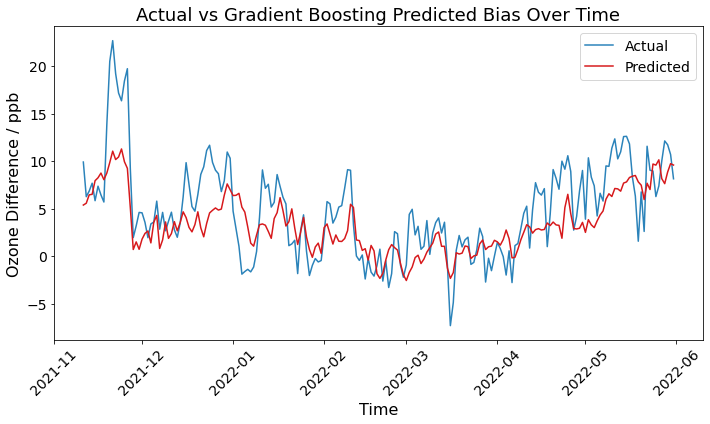

In [19]:
# Convert the 'time' column to datetime
test_df.loc[:, 'time'] = pd.to_datetime(test_df['time'])

# Set the 'time' column as the index for test_df
test_df.set_index('time', inplace=True)

# Set the index of y_test to match test_df's index
y_test.index = test_df.index

# Resample data to daily intervals and calculate daily averages
daily_test_df = test_df.resample('D').mean()
daily_y_test = y_test.resample('D').mean()  # Calculate daily averages for y_test
daily_y_pred = pd.Series(y_pred, index=test_df.index).resample('D').mean()  # Resample y_pred to daily intervals and calculate daily averages

# Time series plot for predicted and observed values
plt.figure(figsize=(10, 6))
plt.plot(daily_test_df.index, daily_y_test, label='Actual', color='#2b83ba')
plt.plot(daily_test_df.index, daily_y_pred, label='Predicted', color='#d7191c')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Ozone Difference / ppb', fontsize=16)
plt.title('Actual vs Gradient Boosting Predicted Bias Over Time', fontsize=18),
plt.tick_params(axis='both', which='major', labelsize=14) 
plt.legend(fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/home/ajp255/nethome/Data/MLPlots/gradient_boosting_timeseries.png', dpi=600)
plt.show()